In [271]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Multivariate Hawkes process

## Notation

We consider a set of users enumerated by the set $\{1,2,\cdots,U\}$ that each have a multivariate Hawkes process definining their violations of a set of $P$ policies. The time of the $k^{th}$ violation of policy $p \in \{1,2,\cdots,P\}$ by user $u \in \{1,2,\cdots,U\}$ is denoted by $t_{upk}$. Each process has a counting process associated with their violation of each policy, which we denote by $N_{up} = \sum_{k=1}^{M_{up}}\mathbb{I}_{[0,t]}(t_{upk})$, where $M_{up}$ is the number of violations of policy $p$ by user $u$. In the simple case, we take the intensity function for the $p^{th}$ process for user $u$ to be:

$\lambda_{up}(t|\mathcal{H}_{ut}) = \lambda_p + \sum_{j=1}^P\sum_{k=1}^{N_{uj}(t)}\beta_{jp}\exp\left\{-\theta_{jp}(t - t_{ujk})\right\}$

Note that this says that the parameters $\{\beta_{jp}\}$, $\{\theta_{jp}\}$ are the same for each user (i.e. that each user violates each policy according to the same Hawkes process, and that the interactions between the violation of each policy is the same). Furthermore, the background rate for process $p$, $\lambda_p$, is considered to be constant for each user.

## Simple example

We start by considering the simplest case. Namely, we take there to be one user and $P=2$ policies. This corresponds to a bivariate Hawkes process. We won't enforce symmetry between the processes however, meaning that mutual excitation is asymmetric. This gives a parameters: $\lambda = (\lambda_1, \lambda_2)^T$, $\beta = (\beta_{11}, \beta_{21}, \beta_{12}, \beta_{22})^T$ and $\theta = (\theta_{11}, \theta_{21}, \theta_{12}, \theta_{22})^T$.

The algorithm implemented here is from Lim et al. (2016).

In [413]:
# Define the parameters
U = 1; P = 2
lam = np.array([1, 1])
theta = np.array([5, 3, 2, 4]).reshape((P,P)) # Input as (theta_{11}, theta_{21},...)
beta = np.array([1, 0, 0, 1]).reshape((P,P))
T_max = 50

def multivariate_Hawkes(P: int, lam: np.array, theta: np.array,
                        beta: np.array, T_max: int) -> np.array:
    """
    A function to simulate from a multivariate Hawkes process. Parameters:
        - P: number of processes.
        - lam: array of baseline intensities for each process.
        - beta: array of shape (P^2, ) of excitation parameters, which is input
                in the form (beta_11, beta_21, ..., beta_P-1P, beta_PP).
        - theta: array of shape (P^2, ) of decay parameters, with the same form
                    as beta.
        - T_max: length of the time interval (assuming zero start).
    """

    lam_ints = np.zeros((P, P)) # Stores lambda_m^i(r_{j-1}) in the notation of Lim et al. (2016)
    r = 0. # Initialise the jump time 
    a_ip = np.zeros((P+1, P)) # Matrix s.t. a_ip[i,p] = a^i_{pj} on iteration j
    t_jp = [[] for _ in range(P)] # List of lists to store event j for process p
    t_process = [] # List to store the type of each arrival

    while r < T_max:
        for p in range(P):
            a_ip[0,p] = np.random.exponential(scale=1/lam[p], size=1)[0] # Numpy parameterises by scale
            for i in range(P):
                u = np.random.uniform(size=1)[0]
                if u < (1 - np.exp(-lam_ints[i, p] / theta[i,p])):
                    a_ip[i+1,p] = (
                        -np.log(1 + theta[i,p] * np.log(1 - u) / lam_ints[i, p]) / theta[i,p]
                    )
                else:
                    a_ip[i+1, p] = np.inf # Index shift cos we count 0 -> P inc.

        # Find the minimum value of a_ip (call this d) and update r
        d = np.min(a_ip)
        r += d

        if r > T_max:
            pass
        else:
            min_idx = np.argwhere(a_ip == np.min(a_ip)).reshape((2,))
            i_star = min_idx[0]; p_star = min_idx[1]

            # Update lam_ints matrix
            for p in range(P):
                for i in range(P):
                    if i == p_star:
                        lam_ints[i,p] *= np.exp(-theta[i,p] * d)
                        lam_ints[i,p] += beta[i,p]
                    else:
                        lam_ints[i,p] *= np.exp(-theta[i,p] * d)

            # Store the time in the appropriate list
            t_jp[p_star].append(r)
            t_process.append(p_star)

    t_arrival = np.concatenate(t_jp, axis=0)

    t_arrivals_all = np.concatenate(
        [t_arrival.reshape((len(t_arrival), 1)),
        np.array(t_process).reshape((len(t_process),1))],
        axis=1
    )

    return t_arrivals_all

Here we write a function to plot the conditional intensity function of a Hawkes process.

In [408]:
def compute_single_excitation(beta, theta, t_arrival, t_eval):
    """
    Compute the excitation function (without the constant term) for
    one of the processes in a multivariate process. This can then be
    summed to compute the total excitation function. Parameters:
        - beta: excitation parameter.
        - theta: decay parameter.
        - t_arrival: array of the arrival times.
        - t_eval: array of times to evaluate at. 
    """
    exc_func = np.array([(beta * np.exp(-theta * (t - t_arrival[t_arrival < t]))).sum() 
                for t in t_eval])

    return exc_func

def plot_intensity(P: int, t_eval: np.array, ints_func: np.array, t_arrivals_all: np.array):
    """
    Input an array containing evaluations of an intensity function and an
    array of times corresponding to where the intensity function was evaluated.
    This is then plotted. Parameters:
        - P: number of processes
        - t_eval: array of evaluation times.
        - ints_func: array of intensity evaluations.
        - t_arrivals_all: array with column 1 being a list of arrival times and 
                          column 2 the process to which that arrival time belonged.
    """
    baseline = ints_func.min()
    plt.plot(t_eval, ints_func);
    for i in range(P):
        t_arrival = t_arrivals_all[t_arrivals_all[:,1] == i, 0]
        plt.scatter(t_arrival, 
                    np.tile([baseline - baseline/(i+2)], len(t_arrival)), 
                    marker='X',  
                    linewidths=0.1);

    plt.xlabel('t'); plt.ylabel(r"$\lambda(t)$")
    plt.show()

def compute_full_intensity_up(lam_p: float, betas_p: np.array, 
                              thetas_p: np.array, t_arrivals_all: np.array, 
                              t_eval: np.array, plot: bool):
    """
    Compute the full conditional intensity function for a single user and process 
    combination. Namely, this will sum the contributions from each process and 
    add the basline intensity. Parameters:
        - lam_p: lambda for the process and user.T
        - betas_p: list of beta values for the user.
        - thetas_p: list of the theta values for the user.
        - t_arrivals_all: array with column 1 b        beta = beta_jph[j]; theta = theta_jph[j]
eing a list of arrival times and 
                column 2 the process to which that arrival time belonged.
        - t_eval: an array of the time values to evaluate the excitation
                 function at.
        - plot: Boolean for whether to plot the intensity.
    """
    # Find the number of processes 
    P = len(betas_p)

    # Initialise the excitation function with the baseline intensity.
    # We then loop over the processes and add to this list to compute total 
    # value at time t.
    ints_func = np.array([lam_p] * len(t_eval), dtype=float)
    for i in range(P):
        t_arrival = t_arrivals_all[t_arrivals_all[:,1] == i, 0]
        ints_func += compute_single_excitation(betas_p[i], thetas_p[i], t_arrival, t_eval)

    if plot:
        plot_intensity(P, t_eval, ints_func, t_arrivals_all)
    else:
        return ints_func

## Grouped Hawkes process

We now turn our attention to the grouped process on a graph. Namely, wherein there is a group structure within the users. Each group is then assumed to have the same parameters for each Hawkes process.

In [1]:
import numpy as np
from grouped_graphical_hawkes import GroupedExponentialHawkes

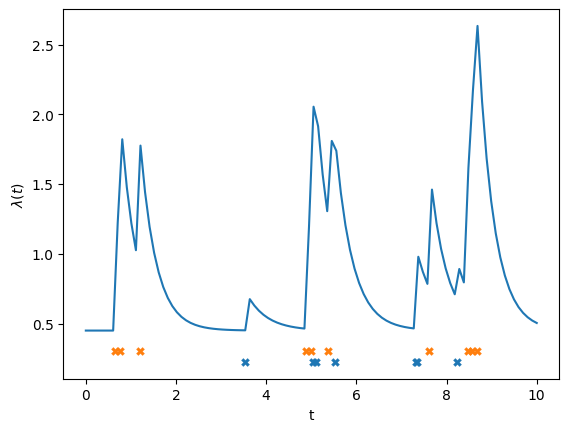

In [73]:
ggh = GroupedExponentialHawkes(G=np.array([3, 2]), P=2, random_all=True)
ggh.simulate_and_plot(1, 1, 1)

In [6]:
ggh.G[1]

2

In [33]:
class Employee():

    def __init__(self, number):
        self.digit = number

    def calculateSalary(self):
        self.salary = self.digit ** 3

In [34]:
employee1 = Employee(number=1)
employee2 = Employee(number=2)

In [40]:
employee2.salary

8